In [1]:
# !pip install perceval-quandela
# !pip install tqdm

In [2]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm

In [3]:
string_data = """[ 0.42668762 -0.30437208  0.34490411  1.1955048   0.99108398 -0.98073023
  1.33923279 -0.24707758 -1.39727401 -0.90303054 -0.60747648 -0.15981591
  1.08421709 -0.26072789  0.40954771  0.11320826  0.41404149 -0.4572002
 -0.02398049  0.47388962  0.57835814  0.25384248  0.33567914  1.43572059
  0.10667714 -0.11351041  1.01496683  0.85053873 -1.29637921 -0.69314184
  1.70169441 -1.03019329 -0.31608486 -0.78674731 -1.24354811  1.19942075
  0.29807439  1.6011203   0.50721155 -0.98282733  0.57251713 -0.59839556
 -0.91734848 -0.65923178 -0.71796508  0.81579074  0.33309176  1.42404329
  0.75067917  0.04116724 -0.67812725 -0.56673834 -0.77006044 -0.90212715
  0.92930667 -1.8936444  -0.29420643 -1.36701839 -0.0395886   0.05748235
 -0.7276859  -0.30396907 -0.50504281 -1.90963989  0.19261934  0.45197476
 -2.0582337   0.88426806 -1.04902813  0.54123997  1.21330168  0.12485084
  0.77574608 -1.29395477 -0.65610766 -0.0917936   0.26544493  0.96836359
 -0.34445437  0.55112846  0.92593937 -1.01738654  0.37395249  0.09276288
 -0.19110181  0.2050793  -0.312579   -0.1228045  -1.99716187  1.19633369
 -3.06059881 -0.5019319  -0.63154318  0.28270956 -1.33994324 -0.89934339
  1.70747107  0.00690676  0.94675141  0.13651856]"""
# Remove brackets and split the string into individual values
values = string_data.strip('[]').split()

# Convert the string values to float and create a numpy array
best_param_from_string = np.array([float(value) for value in values])
# print(best_param_from_string)

In [4]:
nphotons = 5

# random_seed = np.random.randint(0, 10000)
random_seed = 2433
np.random.seed(random_seed)
print("Random Seed:", random_seed)

Random Seed: 2433


In [5]:
# Modeling parameters
n_grid = 200    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 6  # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [6]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [7]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

# def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
#     return u_zegond+np.sin(x)
def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
    # print(len(u_zegond))
    # print(len(u_prime))
    # print(len(u))
    delta = u
    delta_prime = u_prime
    omega = delta_prime+ws
    omega_prime = u_zegond
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [8]:
# # Boundary condition (f(x_0)=f_0)
# x_0 = 0
# f_0 = np.sin(0)

In [9]:
# Differential equation's exact solution - for comparison
def u(x):
    return np.sin(x)

In [10]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / (n_grid - 1)

In [11]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1,1>


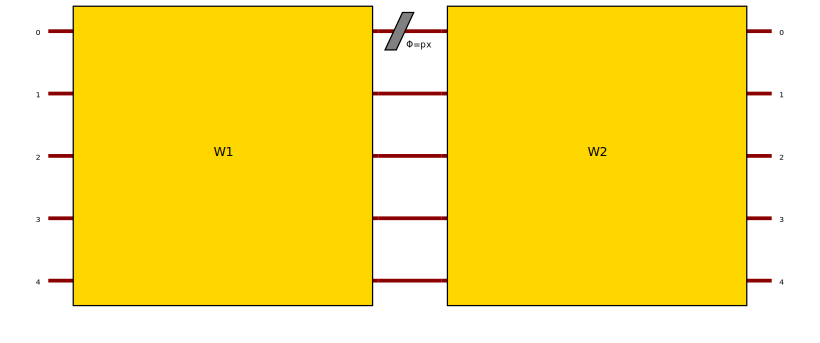

In [12]:
from perceval.simulators import Simulator
from perceval.backends import SLOSBackend

"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)

px = pcvl.P("px")
c = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(px))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:]), name="W2")


backend = pcvl.BackendFactory().get_backend("SLOS")
backend.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend.preprocess([input_state])

pcvl.pdisplay(c)

In [13]:
# best_param = np.load('./seed='+str(random_seed)+' n_photon='+str(nphotons)+'.npy')
# best_param = np.load('seed=5429 n_photon=4 range=0-1 ngrid 50.npy')
best_param =best_param_from_string
print("Unitary parameters", best_param)



Unitary parameters [ 0.42668762 -0.30437208  0.34490411  1.1955048   0.99108398 -0.98073023
  1.33923279 -0.24707758 -1.39727401 -0.90303054 -0.60747648 -0.15981591
  1.08421709 -0.26072789  0.40954771  0.11320826  0.41404149 -0.4572002
 -0.02398049  0.47388962  0.57835814  0.25384248  0.33567914  1.43572059
  0.10667714 -0.11351041  1.01496683  0.85053873 -1.29637921 -0.69314184
  1.70169441 -1.03019329 -0.31608486 -0.78674731 -1.24354811  1.19942075
  0.29807439  1.6011203   0.50721155 -0.98282733  0.57251713 -0.59839556
 -0.91734848 -0.65923178 -0.71796508  0.81579074  0.33309176  1.42404329
  0.75067917  0.04116724 -0.67812725 -0.56673834 -0.77006044 -0.90212715
  0.92930667 -1.8936444  -0.29420643 -1.36701839 -0.0395886   0.05748235
 -0.7276859  -0.30396907 -0.50504281 -1.90963989  0.19261934  0.45197476
 -2.0582337   0.88426806 -1.04902813  0.54123997  1.21330168  0.12485084
  0.77574608 -1.29395477 -0.65610766 -0.0917936   0.26544493  0.96836359
 -0.34445437  0.55112846  0.92593

In [14]:
def plot_solution(m, N, X, optim_params, lambda_random,label):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x/range_max)
        # U = c.compute_unitary(use_symbolic=False)
        # backend.U = U
        backend.set_circuit(c)
        f_theta = np.sum(np.multiply(backend.all_prob(input_state), lambda_random))
        Y.append(f_theta)

    
    plt.plot(X, Y, label=label+" Approximation with {} photons".format(N))
    return Y

In [15]:
y_delta_real = [-0.1, -0.0788451796957863, -0.05767879505453857, -0.03664580324507336, -0.01590511341293927, 0.004381955258555435, 0.024059506659185673, 0.04298604556645252, 0.06104197467057247, 0.07813182347310517, 0.09418757092990773, 0.109170520166757, 0.12306359782582217, 0.13587069621935108, 0.1476153796651598, 0.15833554985188938, 0.16807853314997293, 0.17689694361360753, 0.1848485663767492, 0.19199550843119392, 0.19839761163604197, 0.2041113723496184, 0.20919123146161003, 0.2136895786860371, 0.2176567525612532, 0.22114104044994506, 0.22418685912253414, 0.22683050734509105, 0.22910510215899935, 0.23104142875252362, 0.2326679356161034, 0.23401073454235294, 0.23509360062606122, 0.2359376219794031, 0.2365589974098797, 0.23697123182234647, 0.2371865963781186, 0.23721613435922362, 0.23706966116840145, 0.23675576432910422, 0.23628180348549657, 0.2356537009947777, 0.23487459684969714, 0.23394617509257973, 0.23286955774996412, 0.23164530661983956, 0.23027342327164577, 0.22875334904627312, 0.22708396505606254, 0.2252635921848056, 0.22329006636498888, 0.2211608221286189, 0.21887116952710878, 0.216416232336343, 0.21379137136293003, 0.21099218444420212, 0.2080145064482154, 0.20485440927374984, 0.20150820185030946, 0.1979724301381216, 0.19424387712813806, 0.19031960355583732, 0.1861988231692758, 0.18187936623565892, 0.17735939286454902, 0.1726391550355218, 0.16772099659816617, 0.16260935327208426, 0.15731075264689168, 0.151833814182217, 0.14618924920770218, 0.14038986092300254, 0.13445054439778642, 0.1283882865717358, 0.12222106499526655, 0.11596388608736165, 0.10964588599153648, 0.1032987957475293, 0.09695418276844903, 0.09064345084077546, 0.08439784012435947, 0.0782484271524227, 0.07222612483155787, 0.0663616824417286, 0.06068568563626939, 0.05522855644188512, 0.05002055325865248, 0.045091754239329145, 0.040465195454416264, 0.036161328533027025, 0.032201473968312494, 0.02860295031447414, 0.02537907418676354, 0.02253916026148267, 0.02008852127598369, 0.018028468028669146, 0.016356309378991785, 0.015065352247454781, 0.014145382080674791, 0.013587778801061393, 0.013379790790850686, 0.013505917078217123, 0.013949003580704904, 0.014690243105227948, 0.015709175348069943, 0.016983686894884335, 0.01849001122069428, 0.02020272868989266, 0.0220947665562422, 0.024137521367099225, 0.02630827137178806, 0.02858369575350697, 0.030938231985763946, 0.03334759498982352, 0.03578877713470674, 0.03824004823719137, 0.04068095556181154, 0.04309232382085803, 0.04545625517437821, 0.04775613922894261, 0.04997788053874598, 0.052108152477654955, 0.054134320147649, 0.056045458119015665, 0.05783235043035065, 0.05948749058855769, 0.061005081568848686, 0.06238103581474358, 0.06361297523807055, 0.06470023121896573, 0.06564379912399133, 0.06644396544112281, 0.06710159513617454, 0.06761904593543294, 0.0679994024314951, 0.06824647608326884, 0.06836480521597264, 0.0683596550211357, 0.06823701755659789, 0.06800361174650982, 0.06766688338133274, 0.06723500511783863, 0.06671687647911015, 0.0661213865458643, 0.06545381031729554, 0.06472257492466735, 0.06393659112526143, 0.06310451411493195, 0.06223474352810553, 0.06133542343778102, 0.06041444235552983, 0.05947943323149561, 0.058537773454394496, 0.05759658485151507, 0.05666273368871814, 0.05574283067043697, 0.05484323093967734, 0.053969559174720225, 0.053126232918435136, 0.05231862805747995, 0.05155160174910113, 0.05082938017067195, 0.050155558519692646, 0.04953310101379036, 0.048964340890719084, 0.048450980408359774, 0.04799409084472022, 0.04759411249793522, 0.04725085468626637, 0.046963522977685496, 0.046731677940734864, 0.04655468203859702, 0.04643135597106148, 0.04636022014297114, 0.04633949466422221, 0.04636709934976426, 0.046440653719600225, 0.04655747699878635, 0.046714588117432274, 0.04690870571070094, 0.04713624811880866, 0.047393333387025095, 0.047675779265673256, 0.047979104593085777, 0.04830091190104644, 0.04863902060837192, 0.04898952975059463, 0.04934875373772335, 0.049713222354243164, 0.05007968075911555, 0.05044508948577829, 0.050806624442145516, 0.05116167691060774, 0.051507853548031765, 0.051842976385760804, 0.05216508282961436, 0.052472425659888286, 0.05276347303135481, 0.05303690847326249, 0.05329162103765229]
y_omega_real = [38.39911, 38.40168948082066, 38.399764558202705, 38.392752851437734, 38.38037827790198, 38.362684650438936, 38.34002316265093, 38.31300219872114, 38.28239818287731, 38.24909305419324, 38.21399715939486, 38.177975903456264, 38.14179089041181, 38.106093721062514, 38.0714214084813, 38.03816262161714, 38.0065908574885, 37.97689133049634, 37.94916121877313, 37.923421155748834, 37.89964183189449, 37.87775385682147, 37.857672386557155
, 37.83929766679825, 37.82251503291078, 37.807194909930104, 37.79320353938548, 37.78042599546526, 37.76875021739684, 37.758068333351325, 37.74827670258136, 37.7392759154212, 37.7309707932867, 37.72327222404992, 37.716106318224305, 37.70940690662805, 37.703111204617365, 37.697159804126606, 37.691496673668205, 37.68606915833272, 37.68082797978881, 37.675728294493204, 37.670734147321, 37.66581283238673, 37.660933551730466, 37.6560674985568, 37.65118785723484, 37.6462698032982, 37.64129050344502, 37.636229115537965, 37.63106713961512, 37.62579201777482, 37.620391453272475, 37.61485552804574, 37.609177871615046, 37.60335566108362, 37.59738962113743, 37.59128402404522, 37.58504668965852, 37.5786889854116, 37.572225826321535, 37.56567564751826, 37.55906145758818, 37.552418857265565, 37.54579056952963, 37.53922411293435, 37.53277180160849, 37.526490745255614, 37.52044284915405, 37.514694814156925, 37.50931813669214, 37.50438910876238, 37.49998881794514, 37.49620314739265, 37.493116770065406, 37.49077827216, 37.48927791622052, 37.48870199767401, 37.48911977481771, 37.49058346881903, 37.49312826371561, 37.496772306415245, 37.501516706695945, 37.507345537205914, 37.51422583346354, 37.52210759385741, 37.530923779646315, 37.540590390979325, 37.55103462873459, 37.56216623148457, 37.57387081670377, 37.58603477354064, 37.59854526281756, 37.61129021703083, 37.62415834035069, 37.637039108621316, 37.64982276936081, 37.662400341761206, 37.67466637100115, 37.68654388243414, 37.697945874491815, 37.7087892374841, 37.719001810387894, 37.72852238084714, 37.737300685172755, 37.74529740834271, 37.752484184001936, 37.75884359446243, 37.76436917070315, 37.76906516141002, 37.772931810961865, 37.77597617789367, 37.77821710064043, 37.77967896492555, 37.78039170376081, 37.7803907974464, 37.7797172735709, 37.778417707011286, 37.77654421993291, 37.77415437262238, 37.771295163315074, 37.76801494865745, 37.76436945470092, 37.760412243393695, 37.75619471258081, 37.75176609600409, 37.74717346330218, 37.74246172001054, 37.73767360756141, 37.732849703283875, 37.7280282931445, 37.723240779548775, 37.71851980533291, 37.71389802327327, 37.709405055818, 37.70506749508695, 37.70090890287172, 37.69694981063564, 37.69320771951378, 37.689697100312976, 37.68642939351176, 37.683413009260434, 37.68065332738102, 37.67815340528914, 37.6759198470402, 37.67395776742881, 37.67226989945315, 37.67085702937192, 37.66971799670438, 37.668849694230325, 37.668247067990116, 37.66790311728464, 37.66780889467534, 37.6679535059842, 37.66832411029377, 37.668905919947115, 37.669682200547875, 37.670637178661735, 37.67176131692216, 37.67303811885343, 37.67445057838822, 37.67598177822314, 37.67761488981874, 37.67933317339951, 37.6811199779539, 37.682958741234245, 37.68483298975687, 37.68672633880202, 37.68862249241387, 37.69050546352365, 37.69236508742345, 37.69418839962844, 37.69596108418528, 37.69767026563876, 37.69930450903184, 37.700853819905596, 37.70230964429927, 37.70366486875024, 37.704913820294024, 37.70605226646431, 37.70707741529291, 37.707987915309786, 37.708783855543054, 37.70946676461947, 37.71003757930888, 37.71049635585033, 37.71084466845737, 37.71108475008572, 37.711219492433216, 37.71125244593984, 37.7111878197877, 37.71103048190107, 37.710785958946325, 37.71046043633199, 37.71006075820875, 37.70959442746938, 37.709069605748844, 37.70849511342421, 37.7078804296147, 37.70723528101599]
# y_delta_real = [-0.1, -0.08583339672681049, -0.07164160445474957, -0.05746541455018758, -0.043349533900744155, -0.029341472379610736, -0.015490248233323282, -0.0018442164524273836, 0.01154922233269212, 0.024644735308884922, 0.03740084123776386, 0.04978054430507171, 0.06175176213175188, 0.07328727803726343, 0.08436505223258099, 0.09497023731675054, 0.10509274984115201, 0.11472673202402761, 0.12387055175048226, 0.13252680257248262, 0.14070225462039962, 0.14840650741940042, 0.15565208077446424, 0.162453099281411, 0.16882472977607915, 0.17478318133432622, 0.18034570527202837, 0.18553059514508116, 0.19035689253909124, 0.1948426428976642, 0.19900508897340943, 0.2028610599303449, 0.20642697151450523, 0.2097188260539417, 0.2127522124587222, 0.21554230622093148, 0.21810386941467055, 0.22045125069605762, 0.22259818719507857, 0.22455620704570456, 0.22633573288125447, 0.2279467517080962, 0.22939877956713223, 0.2307008615337995, 0.23186157171806962, 0.23288901326444864, 0.23379081835197718, 0.23457414819423045, 0.23524569308980228, 0.23581150374074694, 0.23627631206762756, 0.23664430181329563, 0.23691940923942054, 0.23710532312648944, 0.23720548477380726, 0.23722308799949673, 0.2371610791404984, 0.23702215705257057, 0.23680877311028942, 0.23652313120704888, 0.23616718775506054, 0.23574253001645568, 0.23524997923726765, 0.23469008997703894, 0.23406330472197334, 0.233369953043247, 0.23261025159700843, 0.23178430412437845, 0.23089210145145025, 0.22993352148928942, 0.2289083292339338, 0.22781617676639368, 0.2266566032526517, 0.22542903494366281, 0.2241327851753542, 0.22276724044905713, 0.22133137906199052, 0.21982367220586307, 0.21824263578671807, 0.2165868334845488, 0.21485487675329862, 0.21304542482086095, 0.21115718468907918, 0.20918891113374705, 0.20713940670460781, 0.2050075217253553, 0.20279215429363304, 0.20049225028103482, 0.19810680333310454, 0.1956348548693358, 0.19307549408317276, 0.19042785892834335, 0.1876912051282258, 0.18486499447295723, 0.18194894835458267, 0.17894306730216042, 0.17584763098176234, 0.17266319819647385, 0.16939060688639385, 0.16603097412863455]
# y_omega_real = [38.39911, 38.401299655130565, 38.401575422949456, 38.399719901730016, 38.395572352037746, 38.3890342397665, 38.38007279032815, 38.36871873908312, 38.35506626910548, 38.3392647705979, 38.32151287957913, 38.30204022176835, 38.28109867190314, 38.258961321209455, 38.23590217012037, 38.212193246972774, 38.18808960802549, 38.163824138196475, 38.139607551062795, 38.11562838886067, 38.09205300010923, 38.069019627397445, 38.046632748173664, 38.024977055143445, 38.004119497151, 37.98410927917925, 37.964977862349755, 37.946738963922755, 37.92939393309099, 37.91293608752996, 37.897346347232876, 37.88260248255641, 37.86867925865441, 37.85554843547796, 37.84317876777532, 37.83153600509199, 37.82058289177068, 37.81027916695127, 37.8005828618055, 37.791458900722056, 37.782873095792326, 37.774791682671896, 37.76718174979811, 37.76001123839011, 37.75324894244879, 37.746864508756815, 37.740828436878616, 37.735112079160416, 37.72968764075802, 37.72452913635611, 37.71961484495394, 37.714924526136166, 37.7104386200426, 37.70613824736816, 37.702005209362895, 37.69802198783197, 37.694171745135684, 37.69043832418946, 37.68680624846384, 37.68326072198449, 37.6797876293322, 37.6763741877512, 37.67301005859815, 37.669685215832324, 37.666390022081465, 37.66311524129595, 37.659852038748774, 37.65659198103559, 37.65332703607467, 37.65004957310693, 37.646752362695885, 37.643428576727736, 37.64007178841127, 37.636675972277935, 37.6332355041818, 37.629746197985774, 37.62620485907272, 37.62260754141544, 37.61895100287678, 37.61523271634101, 37.611450869713835, 37.60760436592232, 37.60369282291497, 37.5997165736617, 37.59567666615383, 37.59157486340406, 37.587413643446546, 37.583196199336825, 37.57892643915184, 37.574608985989954, 37.570249177970936, 37.565853113910485, 37.56142984070527, 37.5569895697469, 37.55254295130256, 37.5481018982482, 37.54367958606844, 37.539290452856626, 37.534950199314814, 37.53067578875376]


Text(0, 0.5, 'del_t')

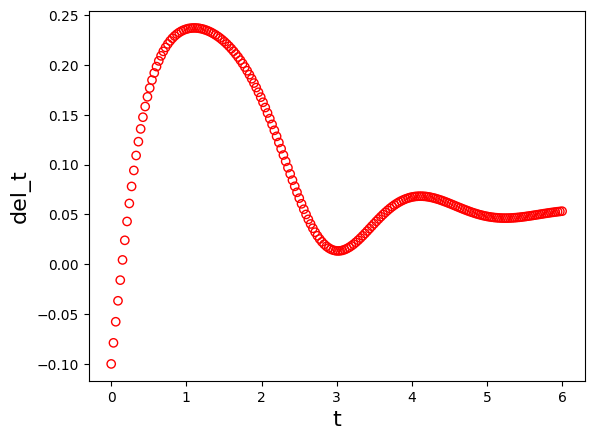

In [16]:
plt.figure()

plt.scatter(X,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
# plt.scatter(X,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)

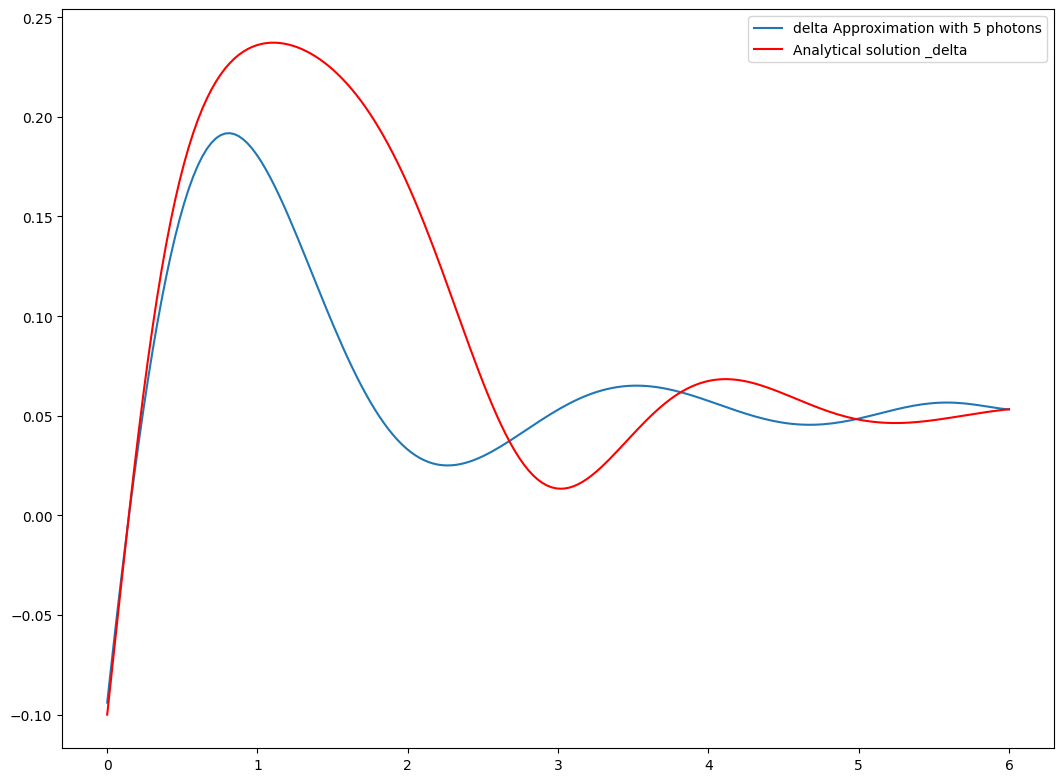

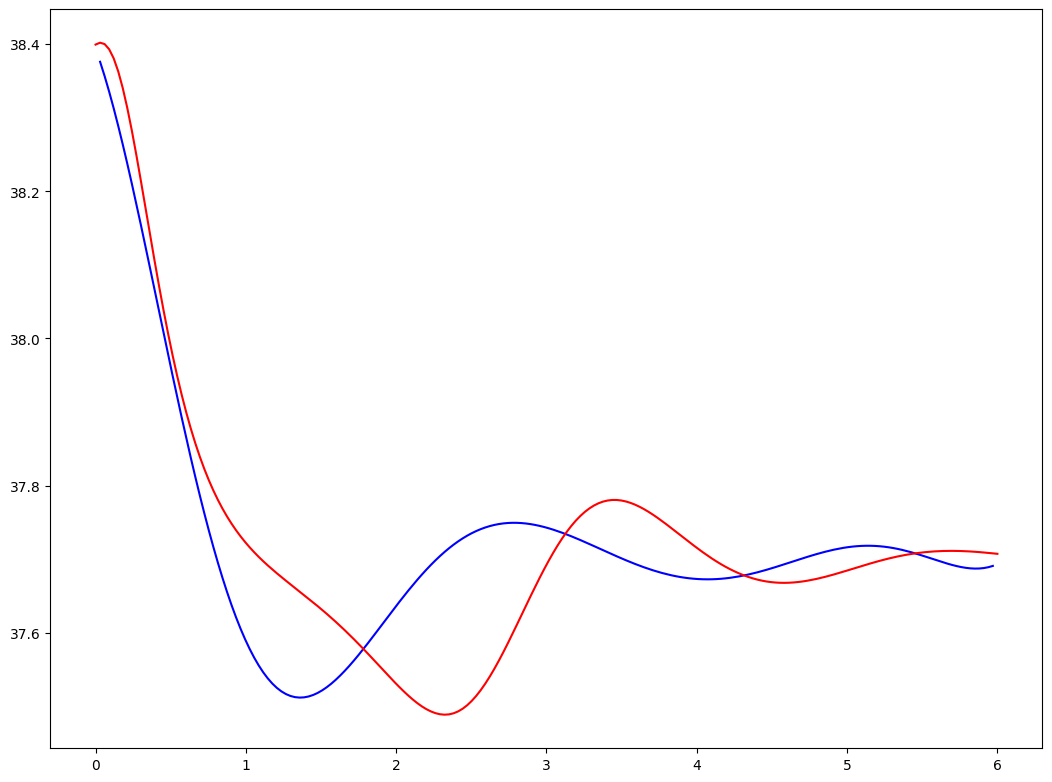

In [17]:
# X = np.linspace(range_min, range_max, 50)

# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# delta_pred = plot_solution(m, N, X, res.x, lambda_random,'delta')
delta_pred = plot_solution(m, N, X, best_param, lambda_random,'delta')

plt.plot(X, y_delta_real, 'r', label='Analytical solution _delta')
plt.legend()

plt.figure()

delta_pred = np.array(delta_pred)
delta_prime = (delta_pred[2:] - delta_pred[:-2])/(2*dx)
omega = delta_prime+ws
plt.plot(X[1:-1], omega, 'b', label='prediction solution _omega')
plt.plot(X, y_omega_real, 'r', label='Analytical solution _omega')
# plt.legend()


plt.show()

In [18]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")

NameError: name 'loss_evolution' is not defined